# Forecasting with Time Series Data 

Typically when working with time series data you will want to try to produce a forecast - we often want to use what we know about a variable's recorded time series to help us infer what the time series will do in the future. 

We ultimately want to create the best predictive model we can, but to be able to evaluate that we need to begin with a **baseline**, or a first-cut predictive model. This allows us to first determine if we can even forecast on the data at hand, and gives us a comparison point for when we attempt to do more advanced forecasting technizues later. 

## Set up workspace

Let's first set up our workspace by bringing in some packages & re-defining our `run_adfuller` function which runs & prints the result of the Dickey Fuller test for us. 

In [94]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from pandas.tseries.frequencies import to_offset
import statsmodels as sm
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tools.eval_measures as stateval

import scipy

def run_adfuller(timeseries):
    # drop nans
    timeseries = timeseries.dropna()
    # run test
    dftest  = stattools.adfuller(timeseries)
    # printer
    if dftest[0] < dftest[4]['1%']:
        print('the time series is stationary within a 99% confidence level')
    if dftest[0] > dftest[4]['1%']:
        print('the time series is not stationary')
    # return 
    return dftest


## Persistence Model 

A **persistence model** is used as the baseline for data without an obvious seasonal trend. In short, it uses each value to help predict the next value. It doesn't know anything about the time series properties! Let's read in `RetailFood_sub.csv` and create a persistence model based on it. 

We must first do some basic preparations such as a common transformation of the `Month` and `Year` columns to build a date column for our dataframe. We will also make sure there are no missing values (and if there are we would interpolate them). 

https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/


In [57]:
food = pd.read_csv('RetailFood_sub.csv', )
food['Year'] = food['Year'].astype(str)
food['Date'] = pd.to_datetime(food["Year"] + "/" + food["Month"])
food.drop(columns = {'Year', 'Month'}, inplace = True)
food = food[['Date', 'Sales']]
food['Sales'] = food['Sales']/1000

print(food.isna().sum())
food.head()

Date     0
Sales    0
dtype: int64


,Date,Sales
0,2013-02-01,416.603
1,2013-03-01,413.848
2,2013-04-01,412.655
3,2013-05-01,414.182
4,2013-06-01,415.777


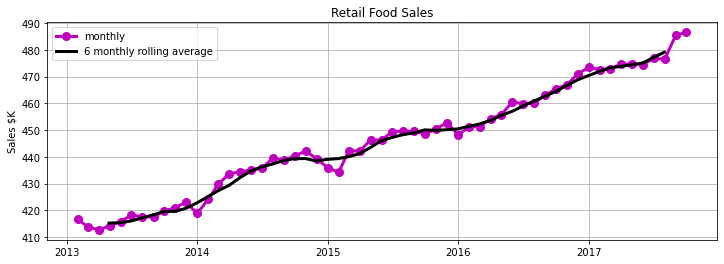

In [58]:
# get rolling average
food_roll = food.set_index('Date').rolling(6).mean()
food_roll.reset_index(inplace = True)
food_roll['Date_offset'] = food_roll['Date'] - to_offset('3M')

# plot 
plt.figure(figsize = (12, 4))
plt.plot(food['Date'], food['Sales'], c = 'm', marker = 'o', 
         linewidth = 3, markersize = 8, label = 'monthly')
plt.plot(food_roll['Date_offset'], food_roll['Sales'], c = 'k', 
         linewidth = 3, linestyle = '-', label = '6 monthly rolling average')
plt.title('Retail Food Sales')
plt.legend()
plt.ylabel('Sales $K')
plt.grid()

We see this data has an upward trend, and there does not seem to be any seasonal component. We begin creating our persistence model by creating a new column `Sales t-1` that contain the lagged values of `Sales`. We want `Sales t-1` to show the sales of the day previous to the current `Sales` value. We will also **drop** the first row which contains the `NaN`. 

The reason we do this is because a persistence model tends to use a "walk forward" approach, where we assume the next value based on the previous value. 

In [96]:
food_lagged = food
food_lagged['Sales t-1'] = food.Sales.shift(1)
food_lagged = food_lagged.iloc[1:]
food_lagged.head()

,Date,Sales,Sales t-1
1,2013-03-01,413.848,416.603
2,2013-04-01,412.655,413.848
3,2013-05-01,414.182,412.655
4,2013-06-01,415.777,414.182
5,2013-07-01,418.222,415.777


Next we will split our data into a **training** and **testing** dataset. In a persistence model you aren't actually doing any training, but doing this step anyway will help us to plot our observed vs. predicted values more clearly. 

Typically you want to keep around 2/3 of the data for training, and 1/3 of the data for testing. There's no hard rule that specifies exactly how to do the split, but it is usually in this ballpark. We calculate `train_size` accordingly & split the dataframe into:

- `food_train` which contains the oldest 66% of the data, and if we were using a more advanced model would be used to 'train' it but for now is just left alone
- `food_test` which contains the most recent 33% of the data, and is the portion of data we will attempt to predict 

In [97]:
# 66% of data is for training, rest for testing
train_size = int(len(food_lagged) * 0.66)
# split 
food_train = food_lagged.iloc[1:train_size]
food_test = food_lagged.iloc[train_size:]

As we stated, a persistence model is not very "smart" so we are simply going to use the **lagged version** as our predictions. We won't actually do anything to the values but rename them in a way we can keep track of them. 

In [120]:
prediction = food_test['Sales t-1']
truth = food_test['Sales']

And we will plot everything together. Note that we have added a `shift(1)` to the date of the `prediction` line plot to match the offset! 

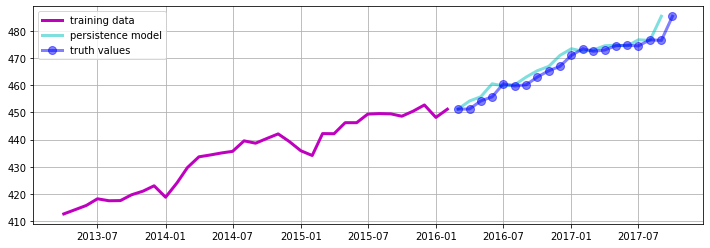

In [114]:
# add training data 
plt.figure(figsize = (12, 4))
plt.plot(food_train['Date'], food_train['Sales'], c = 'm', 
         linewidth = 3, label = 'training data')
# add 
plt.plot(food_test.Date.shift(1), prediction.values, c = 'c', alpha = 0.5, 
         linewidth = '3',  label = 'persistence model')
plt.plot(food_test.Date, prediction.values, c = 'b', alpha = 0.5, 
         linewidth = '3', markersize = 8,  marker = 'o', label = 'truth values')

plt.grid()
plt.legend()

Here we see the results of our model. We did capture the upward trend of the training data, but the location of the actual noise differs. As expected the modeled values are offset from the truth values due to the lag. 

## Quantifying Model Performance 

While it is often fairly easy create a model with the use of the many available statistics packages, it is important to always treat outputs with skepticism. Any forecast model is going to have errors, which are important to quantify to evaluate the model's performance. 

One simple tool is **mean square error**. This gives an overall metric on how the model's predicted values compare to the actual values (refresher [here]). It is effectively the sum of all distances between the predicted line & actual data points, divided by the number of data points. Ideally we would want our MSE to be zero, as that indicates no difference between the modeled and predicted values. The larger the MSE, the more error & therefore the more poorly the model performs. 

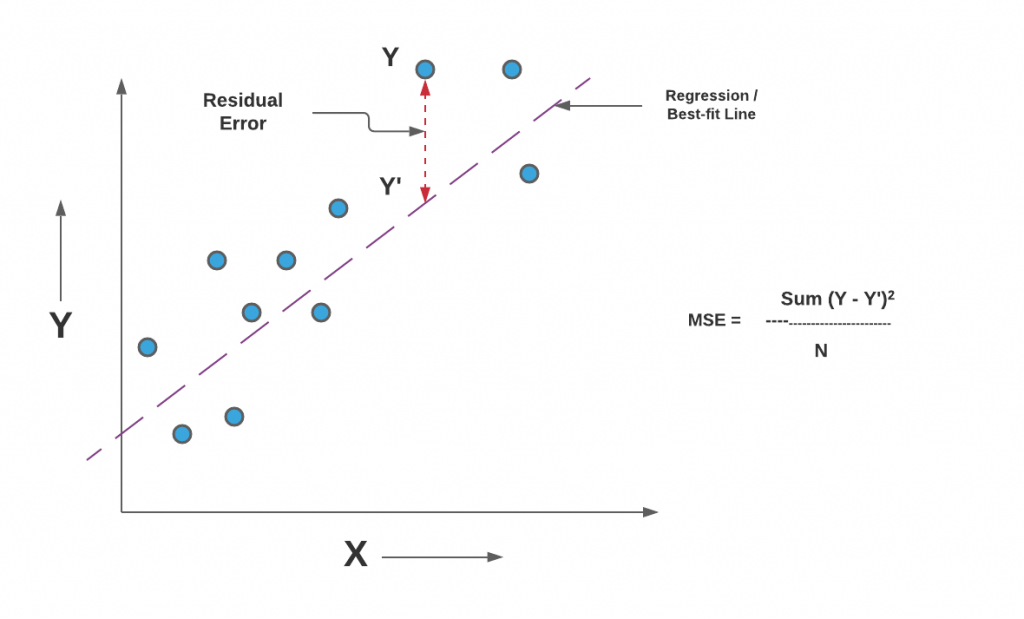

Let's use the `mse` function we imported from `statsmodels.tools.eval_measures`. We simply need to feed it our predicted & actual values. 

In [125]:
test_score = stateval.mse(truth, prediction)
print('Test MSE = ' + str(round(test_score, 3)))

Test MSE = 8.144


Now we have a metric to quantify our model performance! This is useful on its own, but will be much more useful in the future when we train more advanced predictive models. This is our **baseline** for prediction & the accuracy can only go up from here. 

## plotting residuals 

## seasonal persistence 

https://machinelearningmastery.com/seasonal-persistence-forecasting-python/